# Testing Modules for Fiber Application and Datacube Construction

In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time

from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)


0.010955095291137695
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.12 0.52 0.56 0.12 0.   0.   0.  ]
 [0.   0.   0.   0.84 1.   1.   0.84 0.   0.   0.  ]
 [0.   0.   0.16 1.   1.   1.   1.   0.2  0.   0.  ]
 [0.   0.   0.   0.88 1.   1.   0.88 0.   0.   0.  ]
 [0.   0.   0.   0.12 0.56 0.56 0.12 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


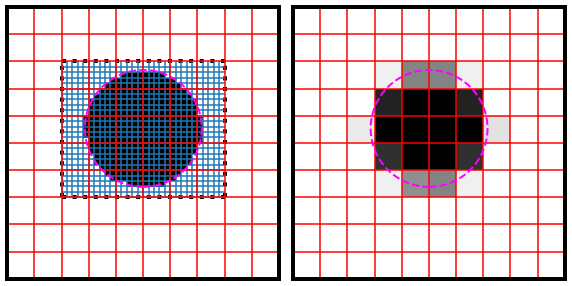

In [2]:
fig,axarr = plt.subplots(1,2,figsize=(10,5))
fig.subplots_adjust(wspace=0.05,hspace=0.05)
axarr = axarr.flatten()

np.random.seed(432910)

for ax in axarr:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_linewidth(4)
        ax.spines[spine].set_zorder(100)

data = np.ones((5,10,10))

data_shape = data.shape
size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]

start = time.time()
Y,X = np.ogrid[0:size_y,0:size_x]

core_diameter_pixels = 4.3
core_radius_pixels = core_diameter_pixels/2
#np.random.seed(0)
core_x_pixels = np.random.uniform(low=4.3,high=5.7)
core_y_pixels = np.random.uniform(low=4.3,high=5.7)

weight_map = np.zeros((size_y,size_x)).astype(int)

weight_map[(np.abs(X+0.5-core_x_pixels)<(core_radius_pixels+0.5))*
           (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1

rows,cols = np.argwhere(weight_map).T
row_min,row_max = np.min(rows),np.max(rows)+1
col_min,col_max = np.min(cols),np.max(cols)+1

rfactor = 5

# # the refined grid is defined to have a minimum of 100 pixels
# # accross the diameter of the fiber
# rfactor = int(100/core_diameter_pixels)
# # if the diameter exceeds 100 pixels already, 
# # use the original regular grid
# if rfactor<1:
#     rfactor = 1
rsize_x,rsize_y = (col_max-col_min)*rfactor,(row_max-row_min)*rfactor
Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
maskr = np.zeros((rsize_y,rsize_x))


maskr[np.sqrt((Xr+col_min*rfactor+0.5 - core_x_pixels*rfactor)**2 +
              (Yr+row_min*rfactor+0.5 - core_y_pixels*rfactor)**2) < core_radius_pixels*rfactor ]=1

weight_mapr = np.zeros((size_y*rfactor,size_x*rfactor))
weight_mapr[row_min*rfactor:row_max*rfactor,col_min*rfactor:col_max*rfactor] = maskr

patch = maskr.reshape(row_max-row_min,rfactor,col_max-col_min,rfactor).sum(axis=(1,3)).astype(float)/rfactor**2

weight_map = weight_map.astype(float)
weight_map[row_min:row_max,col_min:col_max]=patch

core_array = np.sum(data * weight_map.reshape(1,size_y,size_x),axis=(1,2)),np.pi*core_radius_pixels**2

print(time.time()-start)

ax = axarr[0]
ax.imshow(weight_mapr,cmap='Greys',origin='lower',extent=(0,size_x,0,size_y))

core = Circle(xy=(core_x_pixels,core_y_pixels),radius=core_diameter_pixels/2,
              transform=ax.transData,edgecolor='magenta',facecolor='None',linestyle='dashed',linewidth=2,zorder=99)

for i in range((col_max-col_min)*rfactor):
    ax.vlines(i/rfactor+col_min,ymin=row_min,ymax=row_max,color='C0',zorder=2)
    
for i in range((row_max-row_min)*rfactor):
    ax.hlines(i/rfactor+row_min,xmin=col_min,xmax=col_max,color='C0',zorder=2)
    
for i in range(size_x):
    ax.axvline(i,color='red',zorder=3)
    ax.axhline(i,color='red',zorder=3)
    
ax.add_artist(core)

ax = axarr[1]
ax.imshow(weight_map,cmap='Greys',origin='lower',extent=(0,size_x,0,size_y),vmin=0,vmax=1)

for i in range(size_x):
    ax.axvline(i,color='red',zorder=3)
    ax.axhline(i,color='red',zorder=3)

core = Circle(xy=(core_x_pixels,core_y_pixels),radius=core_diameter_pixels/2,
              transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed',zorder=99)

ax.add_artist(core)

ax = axarr[0]
ax.plot([col_min,col_min],[row_min,row_max],c='black',lw=4,zorder=1,linestyle='dotted')
ax.plot([col_min,col_max],[row_min,row_min],c='black',lw=4,zorder=1,linestyle='dotted')
ax.plot([col_min,col_max],[row_max,row_max],c='black',lw=4,zorder=1,linestyle='dotted')
ax.plot([col_max,col_max],[row_min,row_max],c='black',lw=4,zorder=1,linestyle='dotted')

print(weight_map)

fig.savefig('Figures/RealSim-IFS_FiberObserve_example.pdf',bbox_inches='tight')

In [3]:
data = np.ones((1000,512,512))
core_diameter_pixels = 4.3
core_x_pixels = np.random.uniform(low=4.3,high=5.7)
core_y_pixels = np.random.uniform(low=4.3,high=5.7)

def Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels):
    '''`data` must be in format (Nels,spatial_yels,spatial_xels).Nels denotes 
    the number of wavelength/velocity elements. Consequently, data[0] should 
    return a slice of the cube with dimensions (spatial_yels, spatial_xels).'''
    
    data_shape = data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    
    core_radius_pixels = core_diameter_pixels/2
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    # initialize weight map
    weight_map = np.zeros((size_y,size_x)).astype(int)
    # select rectangular region around fiber
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    rows,cols = np.argwhere(weight_map).T
    row_min,row_max = np.min(rows),np.max(rows)+1
    col_min,col_max = np.min(cols),np.max(cols)+1
    
    
    # the refined grid is defined to have a minimum of 100 pixels
    # accross the diameter of the fiber
    rfactor = int(100/core_diameter_pixels)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    if rfactor<1:
        rfactor = 1

    rsize_x,rsize_y = (col_max-col_min)*rfactor,(row_max-row_min)*rfactor
    Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
    maskr = np.zeros((rsize_y,rsize_x))


    maskr[np.sqrt((Xr+col_min*rfactor+0.5 - core_x_pixels*rfactor)**2 +
                  (Yr+row_min*rfactor+0.5 - core_y_pixels*rfactor)**2) < core_radius_pixels*rfactor ]=1

    weight_mapr = np.zeros((size_y*rfactor,size_x*rfactor))
    weight_mapr[row_min*rfactor:row_max*rfactor,col_min*rfactor:col_max*rfactor] = maskr

    patch = maskr.reshape(row_max-row_min,rfactor,col_max-col_min,rfactor).sum(axis=(1,3)).astype(float)/rfactor**2

    weight_map = weight_map.astype(float)
    weight_map[row_min:row_max,col_min:col_max]=patch
    
    return(np.sum(data*weight_map.reshape(1,size_y,size_x),axis=(1,2)))


start = time.time()
core_array = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels)

print(time.time()-start)
size_x = data.shape[2]
size_y = data.shape[1]






1.0950520038604736


In [4]:
x = np.array(1)
y = 1.
x = np.array([y,]).astype(float)

print(type(x)==np.ndarray)
print(x.shape[0])
print(x)

core_x_pixels = 3
if type(core_x_pixels) in [float,int]:
    core_x_pixels = np.array([core_x_pixels,]).astype(float)

print(core_x_pixels)

print(np.array([1,2,3,4]).shape)

print(type(x) in [list,np.ndarray])

True
1
[1.]
[3.]
(4,)
True


0.022635221481323242
10 10


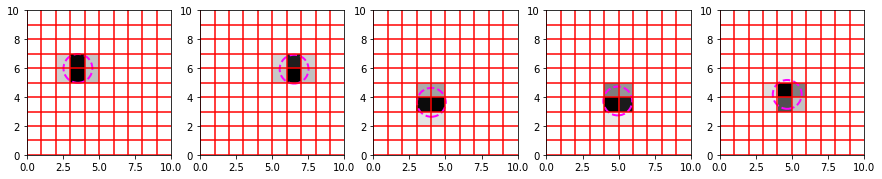

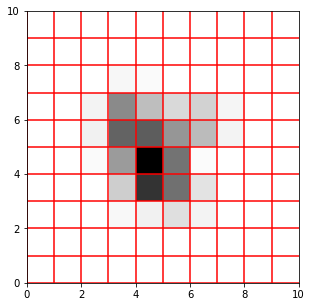

In [5]:
data = np.ones((1024,10,10))
n_fibers = 10
core_diameter_pixels = 2 # np.random.uniform(low=2,high=6,size=n_fibers)
core_x_pixels = np.random.uniform(low=3,high=7,size=n_fibers)
core_y_pixels = np.random.uniform(low=3,high=7,size=n_fibers)
output_grid_dims = (10,10)

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))

        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1

        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
    cube_data = cube_data[np.newaxis,...]    
    core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))
    return (core_array,weight_map) if return_weights else core_array
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4):
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = grid_dimensions_pixels 
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1    
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    if not use_gaussian_weights:
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch/np.sum(patch)
            weight_map[np.isnan(weight_map)]==0.

        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map

start = time.time()
core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=True)
out,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels=output_grid_dims)
print(time.time()-start)

fig,axarr = plt.subplots(1,5,figsize=(15,3))

size_x,size_y = data.shape[2],data.shape[1]
print(size_x,size_y)
#print(weight_map)
for ax,wgt,core_x,core_y,core_diam in zip(axarr.flat,weight_map,core_x_pixels,core_y_pixels,np.ones(5)*core_diameter_pixels):
#     print(np.sum(wgt))
#     print(core_arrays)
    ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

fig,ax = plt.subplots(figsize=(5,5))

ax.imshow(out[0],cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)

for i in range(size_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')


In [33]:
print(fiber_data.shape)

(5,)


SyntaxError: invalid syntax (<ipython-input-210-829aea2328b2>, line 1)

In [6]:
import numpy as np
x = np.array([2,2,2,3,3,3,4,4,4,1,1,2,2,3,3])
y = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1])

y_max = np.max(y)
stat_min = np.zeros(y_max+1)
stat_sum = np.zeros(y_max+1)

for i in np.arange(y_max+1):
    stat_min[i] = np.min(x[y==i])
    stat_sum[i] = np.sum(x[y==i])
    
print(stat_min)
print(stat_sum)

[2. 1.]
[27. 12.]


In [7]:
import numpy as np
x = np.array([2,2,2,3,3,3,4,4,4,1,1,2,2,3,3])
y = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1])

y_max = np.max(y)

stat_min = np.array([np.min(x[y==i]) for i in range(y_max+1)])
stat_sum = np.array([np.sum(x[y==i]) for i in range(y_max+1)])

print(stat_min)
print(stat_sum)

[2 1]
[27 12]


In [8]:
N_fibers = 5

x = 4.
x = np.array([x,]).astype(float)
if x.shape[0] not in [1,N_fibers]:
    raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
if x.shape[0] == 1:
    x.reshape(N_fibers,1,1)
    
print(x)
    

ValueError: cannot reshape array of size 1 into shape (5,1,1)

32 32 10 10 0.3125
0.0011563301086425781


(0, 10)

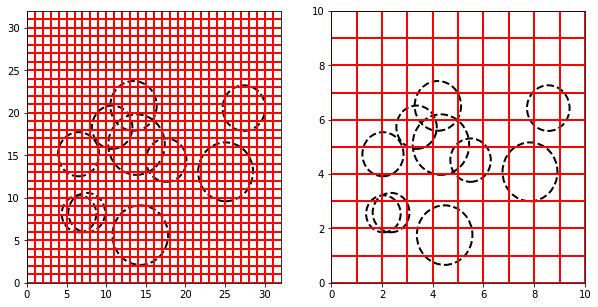

In [9]:
data = np.ones((1024,32,32))
n_fibers = 10
size_y = data.shape[1]
size_x = data.shape[2]
max_fiber_diameter = 8
core_diameter_pixels = np.random.uniform(low=4,high=max_fiber_diameter,size=n_fibers)
core_x_pixels = np.random.uniform(low=max_fiber_diameter/2,high=size_x-max_fiber_diameter/2,size=n_fibers)
core_y_pixels = np.random.uniform(low=max_fiber_diameter/2,high=size_x-max_fiber_diameter/2,size=n_fibers)
output_grid_dims = (10,10)

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    
    if return_weights (default False):
    
        ndarray with shape (N_fibers,spatial_y,spatial_x) which contains weight maps
    for the contribution of each fiber to each pixel in the input grid.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))

        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1

        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
    cube_data = cube_data[np.newaxis,...]    
    core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))
    return (core_array,weight_map) if return_weights else core_array




def Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                  input_grid_dims,output_grid_dims):
    
    '''
    This tool is used to map the fiber core centroid locations on the image plane to a new
    grid covering the same field of view (FOV) but with an arbitrary pixel scale. This pixel
    scale is set by the ratio of `input_grid_dims` to `output_grid_dims`. Consequently, the 
    coordinates of objects in an input grid with dimensions (10,10) could be mapped to (3,3)
    with a scale of 0.333.
    
    Output FOV is always the same as the input FOV! The scale is the only thing that differs.
    The scale must be equal in both x- and y- dimensions. Consequently, an initial grid of 
    (10,15) cannot be scaled to (5,3) as this would require a scale of 2 in the y-direction 
    and a scale of 5 in the x-direction. 
    
    Argument descriptions are the same as for the Fiber_Observe function.
    
    `input_grid_dims` [int,tuple]: 
    The dimensions of the input grid in which the coordinates of the fiber cores are set.
    
     `output_grid_dims` [int,tuple]: 
    The dimensions of the output grid into which the coordinates of the fiber cores are to 
    be determined.
    
    Returns:
    
    
    '''
    
    if type(input_grid_dims)==tuple and type(output_grid_dims)==tuple:
        try:
            osize_y,osize_x = output_grid_dims[0],output_grid_dims[1]
            size_y,size_x = input_grid_dims[0],input_grid_dims[1]
        except:
            raise Exception('Grid dimensions are tuples but do not contain two elements. Stopping...')
    elif type(input_grid_dims)==int and type(output_grid_dims)==int:
        osize_y,osize_x = output_grid_dims,output_grid_dims
        size_y,size_x = input_grid_dims,input_grid_dims
    else:
        raise Exception('Grid dimensions must either be both tuples, e.g. (nrows,ncols), or both ints. Stopping...')
        
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to `core_x_pixels` and `core_y_pixels`. Stopping...")
    
    scale = float(osize_y)/size_y
    scale_x = float(osize_x)/size_x
    if scale_x != scale:
        raise Exception("The scale by which the input coordinates are converted to output coordinates must be the same in x- and y- dimensions. Make sure that `input_grid_dims` and `output_grid_dims` satisfy this condition. Stopping...")
    
    core_x_pixels *= scale
    core_y_pixels *= scale
    core_diameter_pixels *= scale
    print(size_x,size_y,osize_x,osize_y,scale)
    
    return core_x_pixels.flatten(),core_y_pixels.flatten(),core_diameter_pixels.flatten()
    
    
    
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4):
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = grid_dimensions_pixels 
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1    
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    if not use_gaussian_weights:
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch/np.sum(patch)
            weight_map[np.isnan(weight_map)]==0.

        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map

start = time.time()
# core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=True)

out = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,input_grid_dims=(size_y,size_x),output_grid_dims=output_grid_dims)

# out,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels=output_grid_dims)
print(time.time()-start)

fig,axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
for core_x,core_y,core_diam in zip(core_x_pixels,core_y_pixels,core_diameter_pixels):

    #ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='black',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
ax.set_xlim(0,size_x)
ax.set_ylim(0,size_y)

ax = axarr[1]

for core_x,core_y,core_diam in zip(out[0],out[1],out[2]):

    #ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='black',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
ax.set_xlim(0,output_grid_dims[1])
ax.set_ylim(0,output_grid_dims[0])

# fig,ax = plt.subplots(figsize=(5,5))

# ax.imshow(out[0],cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)

# for i in range(size_x):
#     ax.axvline(i,color='red')
#     ax.axhline(i,color='red')


60.6224
60.6224
[[4.     2.5488 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [2.5872 1.1968 0.9456 0.6512 0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.2352 3.9984 4.744  0.3776 0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [1.2608 2.016  3.1296 5.4448 2.4544 0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [3.1632 3.992  0.6496 2.1728 0.8048 0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.5968 1.0816 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.2208 2.6    0.2496 0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     2.56   4.     0.8656 0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.2288 0.8464 0.     0.
  0.     0. 

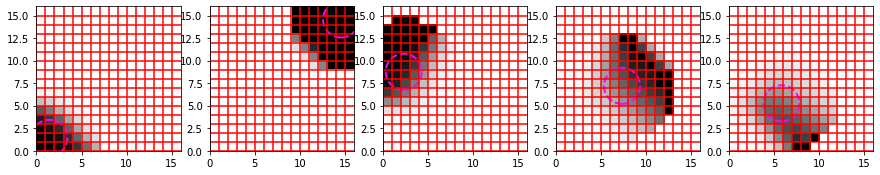

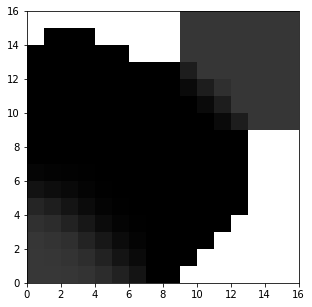

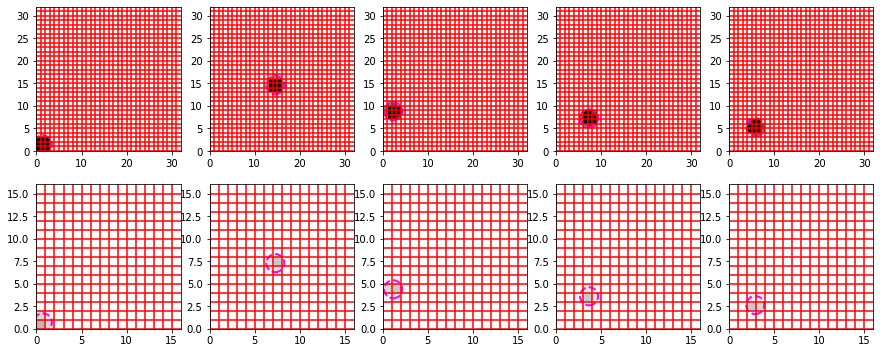

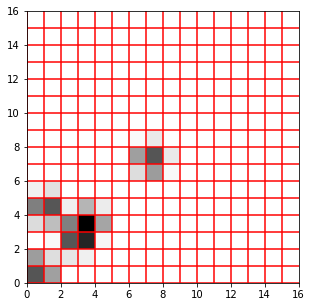

In [2]:
data = np.ones((1024,32,32))
#data[:,:,16:] = 2
n_fibers = 5
size_y = data.shape[1]
size_x = data.shape[2]
max_fiber_diameter = 4
#np.random.seed(1213)
core_diameter_pixels = np.ones(n_fibers)*8 #np.random.uniform(low=1,high=max_fiber_diameter,size=n_fibers)
core_x_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
core_y_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
output_grid_dims = (16,16)

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    
    if return_weights (default False):
    
        ndarray with shape (N_fibers,spatial_y,spatial_x) which contains weight maps
    for the contribution of each fiber to each pixel in the input grid.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))

        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1

        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
    cube_data = cube_data[np.newaxis,...]    
    core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))
    return (core_array,weight_map) if return_weights else core_array


def Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                  input_grid_dims,output_grid_dims):
    
    '''
    This tool is used to map the fiber core centroid locations on the image plane to a new
    grid covering the same field of view (FOV) but with an arbitrary pixel scale. This pixel
    scale is set by the ratio of `input_grid_dims` to `output_grid_dims`. Consequently, the 
    coordinates of objects in an input grid with dimensions (10,10) could be mapped to (3,3)
    with a scale of 0.333.
    
    Output FOV is always the same as the input FOV! The scale is the only thing that differs.
    The scale must be equal in both x- and y- dimensions. Consequently, an initial grid of 
    (10,15) cannot be scaled to (5,3) as this would require a scale of 2 in the y-direction 
    and a scale of 5 in the x-direction. 
    
    The tool also uses the scale to correct for the ratio of intensities that are received by
    an individual pixel in the original grid and that should be received by a new pixel in 
    the output grid. For example, if the original grid has shape (10,10) and the output has
    shape (5,5), the intensity in `core_array` must decrease by a factor of 4 for the new grid
    because every 4 pixels in the original grid are covering the area of 1 pixel in the new 
    grid. This factor must be applied ONLY because there is no normalization of the intensity
    registered by the fibers in `Fiber_Observe`.
    
    Argument descriptions are the same as for the Fiber_Observe function.
    
    `input_grid_dims` [int,tuple]: 
    The dimensions of the input grid in which the coordinates of the fiber cores are set.
    
     `output_grid_dims` [int,tuple]: 
    The dimensions of the output grid into which the coordinates of the fiber cores are to 
    be determined.
    
    Returns:
    
    `core_x_pixels`,`core_y_pixels`,`core_diameter_pixels` scaled to the new grid dimensions.
    
    
    '''
    
    if type(input_grid_dims)==tuple and type(output_grid_dims)==tuple:
        try:
            osize_y,osize_x = output_grid_dims[0],output_grid_dims[1]
            size_y,size_x = input_grid_dims[0],input_grid_dims[1]
        except:
            raise Exception('Grid dimensions are tuples but do not contain two elements. Stopping...')
    elif type(input_grid_dims)==int and type(output_grid_dims)==int:
        osize_y,osize_x = output_grid_dims,output_grid_dims
        size_y,size_x = input_grid_dims,input_grid_dims
    else:
        raise Exception('Grid dimensions must either be both tuples, e.g. (nrows,ncols), or both ints. Stopping...')
        
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to `core_x_pixels` and `core_y_pixels`. Stopping...")
    
    scale = float(osize_y)/size_y
    scale_x = float(osize_x)/size_x
    if scale_x != scale:
        raise Exception("The scale by which the input coordinates are converted to output coordinates must be the same in x- and y- dimensions. Make sure that `input_grid_dims` and `output_grid_dims` satisfy this condition. Stopping...")
    
    core_x_pixels *= scale
    core_y_pixels *= scale
    core_diameter_pixels *= scale
    #print(size_x,size_y,osize_x,osize_y,scale)
    
    return core_x_pixels.flatten(),core_y_pixels.flatten(),core_diameter_pixels.flatten()
    
    
    
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4,rlim_pixels=None):
    
    '''
    With a fiber core array [ndarray] with shape (`N_fibers`,`Nels`) along with their
    x- and y- coordinates (centroid) on a grid of dimensions `grid_dimensions_pixels`,
    this tool computes the intensity contribution of each fiber to each pixel of the grid.
    There are two options:
    
    (1) The intensity is distributed uniformly over all pixels completely contained within
    the fiber and partially within pixels that partially overlap with the fiber. In
    this respect, the method is exactly analogous to Fiber_Observe but in reverse. 
    Pixels that partially overlap with the fiber receive a portion of the intensity that
    is weighted by fraction of area of overlap with respect to a full pixel size. This
    method conserves intensity. This is checked by taking the sum along axis=0 of 
    `fiber_data` (the fiber axis) and comparing to the sum in each wavelength/losvd 
    slice (axis=(1,2)) of the output datacube. The output cube will therefore have a
    total sum that is equal to the sum of fiber_data, but distributed on the grid. 
    
    (2) The weights are determined by adopting a gaussian distribution of the intensity from
    each fiber on the output grid. This method emulates the SDSS-IV MaNGA data reduction
    pipeline. Specifically, see LAW et al. 2016 (AJ,152,83), Section 9.1 on the 
    construction of the regularly sampled cubes from the non-regularly sampled fiber
    data. The intensity contribution from each fiber, f[i], to each regularly spaced output
    pixel is mapped by a gaussian distribution:
    
    w[i,j] = exp( -0.5 * r[i,j]^2 / sigma^2 )
    
    where r[i,j] is the distance between the fiber core and the pixel centroid and 
    sigma is a constant of decay (taken to by 0.7 arcsec for MaNGA, for example). 
    These weights are necessarily normalized to conserve intensity. 
    
    W[i,j] = w[i,j] / SUM(w[i,j]) from k=1 to N_fibers 
    
    Where the sum is over all fibers. Note that there is a distinction between the 
    N_fibers used in LAW et al. 2016 and the one used here. Here, N_fibers refers
    to all fibers from all exposures (equivalent to the N used by LAW et al. 2016). 
    Additionally, the `alpha` parameter used in LAW et al. 2016 is computed and applied
    to the intensities. `alpha` converts the "per fiber" intensity to the "per pixel"
    intensity in the new grid. #Since all units are in pixels and the 
    
    
    '''
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = grid_dimensions_pixels 
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    if not use_gaussian_weights:
        
        # initialize weight map
        weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

        # select rectangular region around fiber to refine for weight estimates
        weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
                   (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1

        indices = np.argwhere(weight_map)
        slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]

        row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
        row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
        col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
        col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]

        # the refined grid is defined to have a minimum of 100 pixels
        # across the diameter of the fiber
        rfactor = (100/core_diameter_pixels).astype(int)
        # if the diameter exceeds 100 pixels already, 
        # use the original regular grid
        rfactor[rfactor<1]=1    

        # handling condition where a single core diameter is given
        if len(rfactor)==1 and N_fibers>1:
            core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
            rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
        weight_map = weight_map.astype(float)
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch/np.sum(patch)
            weight_map[np.isnan(weight_map)]=0.

        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map
    
    else:
        
        # check `gaussian_sigma_pixels` type
        if type(gaussian_sigma_pixels) in [float,int]:
            gaussian_sigma_pixels = np.array([gaussian_sigma_pixels,]).astype(float)
        elif type(gaussian_sigma_pixels) in [list,np.ndarray]:
            gaussian_sigma_pixels = np.array(gaussian_sigma_pixels).astype(float)
        else:
            try: 
                gaussian_sigma_pixels = np.array([float(gaussian_sigma_pixels),])
            except:
                raise Exception("`gaussian_sigma_pixels` not in accepted format. Use a list, numpy array, int, or float. Stopping...")

        # gaussian_sigma_pixels not necessarily constant but may be particular to each fiber
        if gaussian_sigma_pixels.shape[0] not in [1,N_fibers]:
            raise Exception("`gaussian_sigma_pixels` must either be a single float (all/any fibers have the same sigma) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")

        # handling condition where a gaussian_sigma_pixels is given
        if len(gaussian_sigma_pixels)==1 and N_fibers>1:
            gaussian_sigma_pixels = np.ones((N_fibers),dtype=int).flatten()*gaussian_sigma_pixels.flatten()
        
        # generate cube of 2d gaussian pdfs with output grid dimensions
        r2 = ((X+0.5)-core_x_pixels)**2 + ((Y+0.5)-core_y_pixels)**2
        weight_map = np.exp(-r2/gaussian_sigma_pixels.reshape(N_fibers,1,1)**2)
        
        # for each fiber, all pixel weights outside `rlim_pixels` are zero
        if rlim_pixels is not None:
            
            if type(rlim_pixels) in [float,int]:
                rlim_pixels = np.array([rlim_pixels,]).astype(float)
            elif type(rlim_pixels) in [list,np.ndarray]:
                rlim_pixels = np.array(rlim_pixels).astype(float)
            else:
                try: 
                    rlim_pixels = np.array([float(rlim_pixels),])
                except:
                    raise Exception("`rlim_pixels` not in accepted format. Use a list, numpy array, int, or float. Stopping...")

            # gaussian_sigma_pixels not necessarily constant but may be particular to each fiber
            if rlim_pixels.shape[0] not in [1,N_fibers]:
                raise Exception("`rlim_pixels` must either be a single float (all/any fibers have the same sigma) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")

            # handling condition where a gaussian_sigma_pixels is given
            if len(rlim_pixels)==1 and N_fibers>1:
                rlim_pixels = np.ones((N_fibers),dtype=int).flatten()*rlim_pixels.flatten()
        
            weight_map[np.sqrt(r2)>rlim_pixels.reshape(N_fibers,1,1)] = 0
        
        # normalization to determine intensity contribution of each fiber to each pixel
        # as in LAW et al 2016
        alpha = 1./(np.pi*(core_diameter_pixels/2.)**2)
        normalization = np.sum(weight_map,axis=0)
        normalization[normalization==0]=np.nan
        weight_map/=normalization

        weight_map*=alpha.reshape(N_fibers,1,1)
        weight_map[np.isnan(weight_map)]=0
        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map
    

core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,
                                       return_weights=True)

core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                                                                 input_grid_dims=(size_y,size_x),
                                                                 output_grid_dims=output_grid_dims)

out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=3.,rlim_pixels=6.)

fig,axarr = plt.subplots(1,5,figsize=(15,3))

for i in np.arange(weight_map.shape[0]):
    ax = axarr[i]
    ax.imshow(weight_map[i],extent=(0,output_grid_dims[1],0,output_grid_dims[0]),cmap = 'Greys',origin='lower',vmin=0,)
    for j in range(output_grid_dims[1]):
        ax.axvline(j,color='red')
        ax.axhline(j,color='red')
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels[i]/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(out_cube[0],extent=(0,output_grid_dims[1],0,output_grid_dims[0]),cmap = 'Greys',origin='lower',vmin=0)


fig,axarr = plt.subplots(2,5,figsize=(15,6))
core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=True)

for ax,wgt,core_x,core_y,core_diam in zip(axarr.flat[:5],weight_map,core_x_pixels,core_y_pixels,core_diameter_pixels):
#     print(np.sum(wgt))
#     print(core_arrays)
    ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0,vmax=1)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

print(np.sum(core_arrays[:,0]))
core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,input_grid_dims=(size_y,size_x),output_grid_dims=output_grid_dims)



out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels=output_grid_dims)


# norm = np.sum(weight_map,axis=0)
# norm[norm==0.] = np.nan
# out_cube = out_cube/norm
# out_cube[np.isnan(out_cube)]=0.

osize_y,osize_x = output_grid_dims

#print(weight_map)
for ax,wgt,core_x,core_y,core_diam in zip(axarr.flat[5:10],weight_map,core_x_pixels,core_y_pixels,core_diameter_pixels):
#     print(np.sum(wgt))
#     print(core_arrays)
    ax.imshow(wgt,cmap='Greys',extent=(0,osize_x,0,osize_y),origin='lower',vmin=0,vmax=1)
    for i in range(osize_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

fig,ax = plt.subplots(figsize=(5,5))
print(np.sum(out_cube[0]))
ax.imshow(out_cube[0],cmap='Greys',extent=(0,osize_x,0,osize_y),origin='lower',vmin=0)

for i in range(osize_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')
print(out_cube[0])
print(np.sum(data,axis=(1,2)))
print(np.sum(out_cube,axis=(1,2)))


# Working Version

Working versions of the fiber application and datacube construction modules for RealSim-IFS.

In [3]:
import numpy as np
from copy import copy

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    
    if return_weights (default False):
    
        ndarray with shape (N_fibers,spatial_y,spatial_x) which contains weight maps
    for the contribution of each fiber to each pixel in the input grid.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
        
    weight_map = weight_map.astype(float)
    core_array = np.zeros((N_fibers,Nels)) 

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))
        
        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
 
        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        core_array[i] = np.sum(cube_data*weight_map[i].reshape(1,size_y,size_x),axis=(1,2))
        
#     cube_data = cube_data[np.newaxis,...] 
#     core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))

    return (core_array,weight_map) if return_weights else core_array


def Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                  input_grid_dims,output_grid_dims):
    
    '''
    This tool is used to map the fiber core centroid locations on the image plane to a new
    grid covering the same field of view (FOV) but with an arbitrary pixel scale. This pixel
    scale is set by the ratio of `input_grid_dims` to `output_grid_dims`. Consequently, the 
    coordinates of objects in an input grid with dimensions (10,10) could be mapped to (3,3)
    with a scale of 0.333.
    
    Output FOV is always the same as the input FOV! The scale is the only thing that differs.
    The scale must be equal in both x- and y- dimensions. Consequently, an initial grid of 
    (10,15) cannot be scaled to (5,3) as this would require a scale of 2 in the y-direction 
    and a scale of 5 in the x-direction. 
    
    The output `core_x_pixels` and `core_y_pixels` will have a coordinate system defined with
    with (0,0) at the upper left corner of the image. Therefore, with output grid dimensions 
    of (10,10), the center of the fiber array would be (5,5).
    
    Argument descriptions are the same as for the Fiber_Observe function.
    
    `input_grid_dims` [int,tuple]: 
    The dimensions of the input grid in which the coordinates of the fiber cores are set.
    
     `output_grid_dims` [int,tuple]: 
    The dimensions of the output grid into which the coordinates of the fiber cores are to 
    be determined.
    
    Returns:
    
    `core_x_pixels`,`core_y_pixels`,`core_diameter_pixels` scaled to the new grid dimensions.
    
    
    '''
    
    if type(input_grid_dims)==tuple and type(output_grid_dims)==tuple:
        try:
            osize_y,osize_x = output_grid_dims[0],output_grid_dims[1]
            size_y,size_x = input_grid_dims[0],input_grid_dims[1]
        except:
            raise Exception('Grid dimensions are tuples but do not contain two elements. Stopping...')
    elif type(input_grid_dims)==int and type(output_grid_dims)==int:
        osize_y,osize_x = output_grid_dims,output_grid_dims
        size_y,size_x = input_grid_dims,input_grid_dims
    else:
        raise Exception('Grid dimensions must either be both tuples, e.g. (nrows,ncols), or both ints. Stopping...')
        
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to `core_x_pixels` and `core_y_pixels`. Stopping...")
    
    scale = float(osize_y)/size_y
    scale_x = float(osize_x)/size_x
    if scale_x != scale:
        raise Exception("The scale by which the input coordinates are converted to output coordinates must be the same in x- and y- dimensions. Make sure that `input_grid_dims` and `output_grid_dims` satisfy this condition. Stopping...")
    
    core_x_pixels *= scale
    core_y_pixels *= scale
    core_diameter_pixels *= scale
    
    return core_x_pixels.flatten(),core_y_pixels.flatten(),core_diameter_pixels.flatten()
    
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4,rlim_pixels=None,
                  use_broadcasting=False):
    
    '''
    With a fiber core array [ndarray] with shape (`N_fibers`,`Nels`) along with their
    x- and y- coordinates (centroid) on a grid of dimensions `grid_dimensions_pixels`,
    this tool computes the intensity contribution of each fiber to each pixel of the grid.
    There are two options:
    
    (1) The intensity is distributed uniformly over all pixels completely contained within
    the fiber and partially within pixels that partially overlap with the fiber. In
    this respect, the method is exactly analogous to Fiber_Observe but in reverse. 
    Pixels that partially overlap with the fiber receive a portion of the intensity that
    is weighted by fraction of area of overlap with respect to a full pixel size. This
    method conserves intensity. This is checked by taking the sum along axis=0 of 
    `fiber_data` (the fiber axis) and comparing to the sum in each wavelength/losvd 
    slice (axis=(1,2)) of the output datacube. The output cube will therefore have a
    total sum that is equal to the sum of fiber_data, but distributed on the grid. 
    
    (2) The weights are determined by adopting a gaussian distribution of the intensity from
    each fiber on the output grid. This method emulates the SDSS-IV MaNGA data reduction
    pipeline. Specifically, see LAW et al. 2016 (AJ,152,83), Section 9.1 on the 
    construction of the regularly sampled cubes from the non-regularly sampled fiber
    data. The intensity contribution from each fiber, f[i], to each regularly spaced output
    pixel is mapped by a gaussian distribution:
    
    w[i,j] = exp( -0.5 * r[i,j]^2 / sigma^2 )
    
    where r[i,j] is the distance between the fiber core and the pixel centroid and 
    sigma is a constant of decay (taken to by 0.7 arcsec for MaNGA, for example). 
    These weights are necessarily normalized to conserve intensity. 
    
    W[i,j] = w[i,j] / SUM(w[i,j]) from k=1 to N_fibers 
    
    Where the sum is over all fibers. Note that there is a distinction between the 
    N_fibers used in LAW et al. 2016 and the one used here. Here, N_fibers refers
    to all fibers from all exposures (equivalent to the N used by LAW et al. 2016). 
    Additionally, the `alpha` parameter used in LAW et al. 2016 is computed and applied
    to the intensities. `alpha` converts the "per fiber" intensity to the "per pixel"
    intensity in the new grid. The resulting `out_cube` conserves intensity from the 
    original cube in the limit where there is adequate sampling of the original cube
    by the fibers. With sparse sampling, the intensity is not necessarily conserved.
    Note that this differes from (1) which only conserves intensities within the 
    fibers themselves. Method (2) also allows a scale, `rlim_pixels` beyond which a 
    fiber contributes no intensity in the output grid (weights are zero). 
    
    `fiber_data` [np.ndarray] with shape (N_fibers,Nels):
    Fiber data arrays. These contain the spectra measured in each fiber to be 
    distributed on the output grid.
    
    `grid_dimensions_pixels`: [int,tuple]
    Dimensions of the output grid. If tuple, should be the (spatial_x,spatial_y)
    shape of the output grid.
    
    `use_gaussian_weights` [boolean]:
    If False (default), use method (1) outlined above. If True, use method (2). 
    If True, the `gaussian_sigma_pixels` and `rlim_pixels` are used to determine 
    the profile of the gaussian distribution used in the weights.
    
    `gaussian_sigma_pixels` [int,float,list,np.ndarray]:
    The characteristic size of the 2d circular gaussian used when
    `use_gaussian_weights` is True. 
    
    `rlim_pixels` [int,float,list,np.ndarray]:
    The distance in pixels from a fiber core beyond which the weights assigned 
    to all pixels in a weight map are zero (default None, i.e. the weights extend
    to infinity). 
    
    `use_broadcasting` [boolean]:
    The broadcasting of the weight maps with the spectra from each fiber to produce
    the output datacubes can be very memory-intensive. You can estimate the memory
    demand by computing (N_fibers*Nels*output_spatial_y*output_spatial_x*64/8/1e9)
    for the size of the object that needs to be summed over the N_fibers dimension
    in Gigabytes. If this exceeds your memory requirements, `use_broadcasting` should
    be set to False. This will greatly increase the computation time at the expense
    of memory intensiveness.
    
    '''
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = int(grid_dimensions_pixels[1]),int(grid_dimensions_pixels[0])
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    if not use_gaussian_weights:
        
        # initialize weight map
        weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

        # select rectangular region around fiber to refine for weight estimates
        weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
                   (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1

        indices = np.argwhere(weight_map)
        slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]

        row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
        row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
        col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
        col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]

        # the refined grid is defined to have a minimum of 100 pixels
        # across the diameter of the fiber
        rfactor = (100/core_diameter_pixels).astype(int)
        # if the diameter exceeds 100 pixels already, 
        # use the original regular grid
        rfactor[rfactor<1]=1    

        # handling condition where a single core diameter is given
        if len(rfactor)==1 and N_fibers>1:
            core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
            rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
        weight_map = weight_map.astype(float)
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
        _weight_map_ = copy(weight_map)
        alpha = np.nansum(weight_map,axis=(1,2)).reshape(-1,1,1)
        normalization = np.nansum(weight_map,axis=0)
        normalization[normalization==0]=np.nan
        weight_map/=normalization
        weight_map[np.isnan(weight_map)]=0.
        weight_map/=alpha
            
        if not use_broadcasting:
            # code to reduce memory demand
            out_cube = np.zeros((Nels,size_y,size_x))
            fiber_data = fiber_data.reshape(N_fibers,Nels,1,1)
            weight_map = weight_map.reshape(N_fibers,1,size_y,size_x)
            for i in range(N_fibers):
                out_cube += fiber_data[i]*weight_map[i]
        else:
            out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        
        return out_cube,_weight_map_
    
    else:
        
        # check `gaussian_sigma_pixels` type
        if type(gaussian_sigma_pixels) in [float,int]:
            gaussian_sigma_pixels = np.array([gaussian_sigma_pixels,]).astype(float)
        elif type(gaussian_sigma_pixels) in [list,np.ndarray]:
            gaussian_sigma_pixels = np.array(gaussian_sigma_pixels).astype(float)
        else:
            try: 
                gaussian_sigma_pixels = np.array([float(gaussian_sigma_pixels),])
            except:
                raise Exception("`gaussian_sigma_pixels` not in accepted format. Use a list, numpy array, int, or float. Stopping...")

        # gaussian_sigma_pixels not necessarily constant but may be particular to each fiber
        if gaussian_sigma_pixels.shape[0] not in [1,N_fibers]:
            raise Exception("`gaussian_sigma_pixels` must either be a single float (all/any fibers have the same sigma) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")

        # handling condition where a gaussian_sigma_pixels is given
        if len(gaussian_sigma_pixels)==1 and N_fibers>1:
            gaussian_sigma_pixels = np.ones((N_fibers),dtype=int).flatten()*gaussian_sigma_pixels.flatten()
        
        # generate cube of 2d gaussian pdfs with output grid dimensions
        r2 = ((X+0.5)-core_x_pixels)**2 + ((Y+0.5)-core_y_pixels)**2
        weight_map = np.exp(-0.5*r2/gaussian_sigma_pixels.reshape(N_fibers,1,1)**2)
        
        # for each fiber, all pixel weights outside `rlim_pixels` are zero
        if rlim_pixels is not None:
            
            if type(rlim_pixels) in [float,int]:
                rlim_pixels = np.array([rlim_pixels,]).astype(float)
            elif type(rlim_pixels) in [list,np.ndarray]:
                rlim_pixels = np.array(rlim_pixels).astype(float)
            else:
                try: 
                    rlim_pixels = np.array([float(rlim_pixels),])
                except:
                    raise Exception("`rlim_pixels` not in accepted format. Use a list, numpy array, int, or float. Stopping...")

            # gaussian_sigma_pixels not necessarily constant but may be particular to each fiber
            if rlim_pixels.shape[0] not in [1,N_fibers]:
                raise Exception("`rlim_pixels` must either be a single float (all/any fibers have the same sigma) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")

            # handling condition where a gaussian_sigma_pixels is given
            if len(rlim_pixels)==1 and N_fibers>1:
                rlim_pixels = np.ones((N_fibers),dtype=int).flatten()*rlim_pixels.flatten()
        
            weight_map[np.sqrt(r2)>rlim_pixels.reshape(N_fibers,1,1)] = 0
        
        # normalization to determine intensity contribution of each fiber to each pixel
        # as in LAW et al 2016
        
        _weight_map_ = copy(weight_map)
        _weight_map_[np.isnan(_weight_map_)]=0
        
        alpha = 1./(np.pi*(core_radius_pixels)**2)
        normalization = np.sum(weight_map,axis=0)
        normalization[normalization==0]=np.nan
        weight_map/=normalization
        weight_map*=alpha
        weight_map[np.isnan(weight_map)]=0
        
        if not use_broadcasting:
            # code to reduce memory demand
            out_cube = np.zeros((Nels,size_y,size_x))
            fiber_data = fiber_data.reshape(N_fibers,Nels,1,1)
            weight_map = weight_map.reshape(N_fibers,1,size_y,size_x)
            for i in range(N_fibers):
                out_cube += fiber_data[i]*weight_map[i]
        else:
            out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        
        return out_cube,_weight_map_
    

## Intensity conservation checks

### Non-Gaussian Weights (Circular Apertures)

In this case, we just want to guarantee that the intensity that is going into the fibers (i.e. `core_array`) is being properly injected into the output (`out_cube`) for the spaxels that are completely encompassed by the fibers. If the input is a cube of ones (1024,32,32), then the theoretical flux measured by cores of radius $r_{\mathrm{core}}$ in a single channel is simply $\pi r^2_{\mathrm{core}}$.

If the input spatial dimensions are (32,32) and the output subtends the same field of view but with dimensions (16,16), each pixel in the output should have a value of $1.\times(32/16)^2 = 4$ where 1 is the value of each element of the original cube. Spaxels which receive partial coverage from one, or multiple fibers should also have this value due to the normalization (conserving flux). Therefore, the theoretical flux of $N_{\mathrm{fibers}}\times \pi r^2_{\mathrm{core}} \times 4$ in each channel is a lower limit if there is no overlap between spaxels covered by each fiber. If there is no overlap between the spaxels subtended by each fiber, the integrated output flux in a given channel should be in $[(2r_{\mathrm{core}}-1)^2, (2r_{\mathrm{core}}+1)^2] \times N_{\mathrm{fibers}} \times 4$. This is a broad range, but nonethess provides a basis for testing.

These predictions of the algorithm are validated in the results of the next cell.

Theoretical flux in core: 50.26548245743669
Theoretical total flux measured in 3 cores: 150.79644737231007
0.04982399940490723
Total flux measured by cores: 150.85416666666666
Flux by first fibre: 50.34027777777778 

Total flux single channel of output  196.14357786544153
Lower limit if no overlap: [108.]
Upper limit if no overlap: [300.]


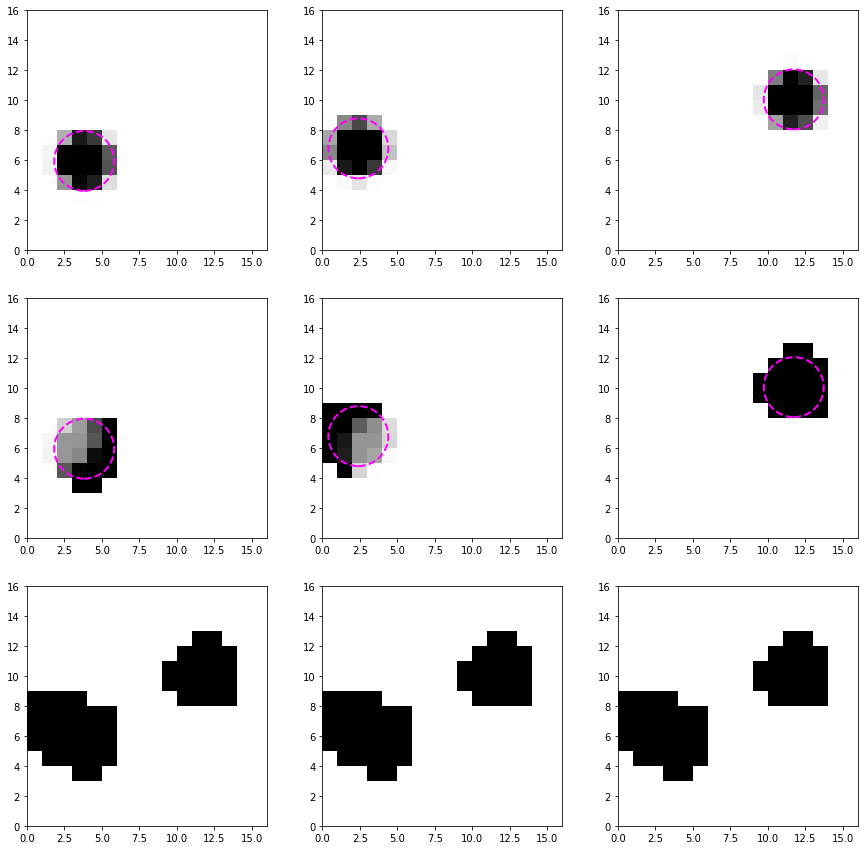

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# from RealSim_IFS import Fiber_Observe
# from RealSim_IFS import Change_Coords
# from RealSim_IFS import Fiber_to_Grid

data = np.ones((1024,32,32))
n_fibers = 3
size_y = data.shape[1]
size_x = data.shape[2]
max_fiber_diameter = 8.
np.random.seed(49819)
core_diameter_pixels = 8. #np.random.uniform(low=1,high=max_fiber_diameter,size=n_fibers)
core_x_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
core_y_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
output_grid_dims = (16,16)

print('Theoretical flux in core: {}'.format(np.pi*(core_diameter_pixels/2)**2))
print('Theoretical total flux measured in {} cores: {}'.format(n_fibers,n_fibers*np.pi*(core_diameter_pixels/2)**2))

start = time.time()
core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,
                                       return_weights=True)

core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                                                                 input_grid_dims=(size_y,size_x),
                                                                 output_grid_dims=output_grid_dims)

out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=False,
                    gaussian_sigma_pixels=1.,rlim_pixels=2)

print(time.time()-start)
print("Total flux measured by cores:", np.sum(core_arrays,axis=0)[0])
print("Flux by first fibre:", core_arrays[0][0],'\n')


print("Total flux single channel of output ", np.sum(out_cube,axis=(1,2))[0])

fig,axarr = plt.subplots(3,3,figsize=(15,15))
axarr = axarr.flatten()

# weight maps after drizzle
for i in np.arange(3):
    ax = axarr[i]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,16,0,16),origin='lower',vmin=0,vmax=1)
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    
# normalized weight maps (including alpha)
alpha = np.nansum(weight_map,axis=(1,2)).reshape(-1,1,1)
normalization = np.nansum(weight_map,axis=0)
normalization[normalization==0]=np.nan
weight_map/=normalization
weight_map[np.isnan(weight_map)]=0.
weight_map/=alpha

for i in np.arange(3):
    ax = axarr[i+3]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,16,0,16),origin='lower')
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    
# output
for i in np.arange(3):
    ax = axarr[i+6]
    ax.imshow(out_cube[i],cmap='Greys',extent=(0,16,0,16),vmin=0,vmax=4,origin='lower')
    

print('Lower limit if no overlap: {}'.format( n_fibers*(core_diameter_pixels-1)**2*(32/16)**2))
print('Upper limit if no overlap: {}'.format(n_fibers*(core_diameter_pixels+1)**2*(32/16)**2))

### Gaussian weights

This method follows the approach of Law et al. 2016 for the SDSS-IV MaNGA data reduction pipeline (Section 9.1) by using circular gaussians to determine the weighted intensity contribution of each irregularly positioned fiber on each regularly spaced output pixel.

For the cicular gaussian weights, we are interested in conserving the intensity from the original image (assuming that it is sufficiently sampled), rather than within an individual fiber (as was the case for the previous test). The test in this case is whether the sum along the spatial axes of the original `data` is the same as the sum along the spatial axes of the output array, `out_cube`.

Note that with only 4 randomly placed fibers and the clause, `rlim_pixels=6`, that the weights are zero on pixels that are >6 pixels away from the fiber cores, the sampling is sufficiently sparse that the sums may not be equivalent.

If we remove this clause, `rlim_pixels=None`, every pixel has a gaussian weight from every fiber and the sums equate. It is immediately obvious that this method **requires** good sampling of the spatial dimensions.

In [4]:
import time
import numpy as np

data = np.ones((1024,32,32))
n_fibers = 4
size_y = data.shape[1]
size_x = data.shape[2]
max_fiber_diameter = 4.
#np.random.seed(1213)
core_diameter_pixels = 4. #np.random.uniform(low=1,high=max_fiber_diameter,size=n_fibers)
core_x_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
core_y_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
output_grid_dims = (16,16)

start = time.time()
core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,
                                       return_weights=True)

core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                                                                 input_grid_dims=(size_y,size_x),
                                                                 output_grid_dims=output_grid_dims)

out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=2.,rlim_pixels=None)

print(time.time()-start)
print("in_cube", np.sum(data,axis=(1,2)))
print("out_cube", np.sum(out_cube,axis=(1,2)))

0.07052111625671387
in_cube [1024. 1024. 1024. ... 1024. 1024. 1024.]
out_cube [1023.69850872 1023.69850872 1023.69850872 ... 1023.69850872 1023.69850872
 1023.69850872]


## More realistic fiber distributions

I now test with the fiber distributions generated with the other modules from RealSim-IFS.

In the cell below, I generate the fiber positions and sizes. I just want the fibers to roughly cover the input cube, which has shape (32,32) above. Therefore, I set an `arcsec_per_pixel` which appropriately scales the fiber positions and radii (in arcsec) to pixels such that they roughly cover the FOV.

The grey shaded regions are the cores of each fiber and the white around them are the cladding. Darker regions are the overlap between neighbouring fibers.

/Users/cbottrell/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


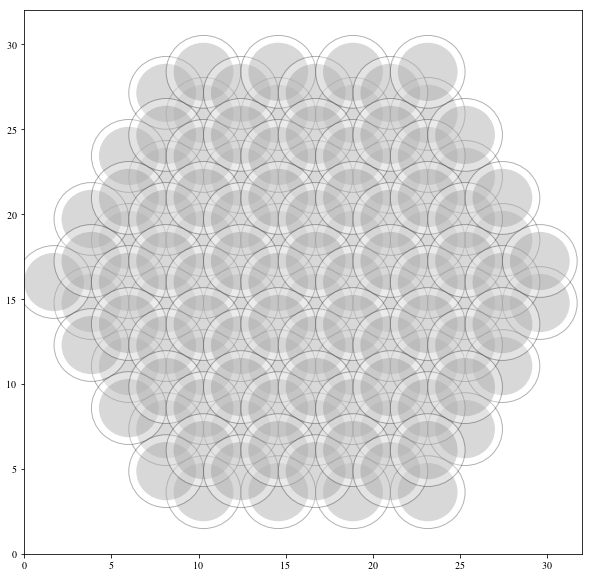

In [5]:
import numpy as np
import os,sys,time
import RealSim_IFS
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='None',
                                           fibers_per_side=4,
                                           n_observations='Classic',
                                           bundle_xoffset_arcsec=0.,
                                           bundle_yoffset_arcsec=0.,
                                           rotation_degrees = 0.,
                                           return_params=True)

fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = xc_arr.shape[-1]

data_shape = 32

size_pixels = 2*(np.max(np.abs(xc_arr))+core_diameter_arcsec/2.)
arcsec_per_pixel = size_pixels/float(data_shape)

# rescale and set new origin
xc_cores_pixels = xc_arr.flatten()/arcsec_per_pixel+data_shape/2.
yc_cores_pixels = yc_arr.flatten()/arcsec_per_pixel+data_shape/2.
diam_cores_pixels = core_diameter_arcsec/arcsec_per_pixel
diam_fibers_pixels = fiber_diameter_arcsec/arcsec_per_pixel

fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0,32)
ax.set_ylim(0,32)

for xy in zip(xc_cores_pixels,yc_cores_pixels):
    clad = Circle(xy=xy,radius=diam_fibers_pixels/2,transform=ax.transData,edgecolor='black',facecolor='White',alpha=0.3)
    ax.add_artist(clad)
    core = Circle(xy=xy,radius=diam_cores_pixels/2,transform=ax.transData,edgecolor='None',facecolor='Grey',alpha=0.3)
    ax.add_artist(core)
        

Now let's examine the output of `Fiber_Observe` which produces `core_arrays` with dimensions (`N_fibers`,`Nels`). Each element of `core_arrays` should be the weighted sum of the data contained within the fiber core aperture in each wavelength/losvd slice. In this case, since the original data is an cube of ones, it is easy to test whether the tool is getting this right. Each element of core_arrays should have a value of $\pi\times r^2_{\mathrm{core}}$. The sum along all the `N_fibers` axis should also be equal to `N_fibers`$\times \pi\times r^2_{\mathrm{core}}$. I check this and find that the code satisfies. 

I also plot the individual weights and find that they look reasonable. The weight maps are aligned with expectations from the fiber positions and diameters.

Time to complete (s): 1.014233112335205 

Comparison of individual elements of core_array:
 9.236623067776456 9.232435553406738
Comparison of sum along N_fibers axis:
 1024.8085612366226 1024.800346428148


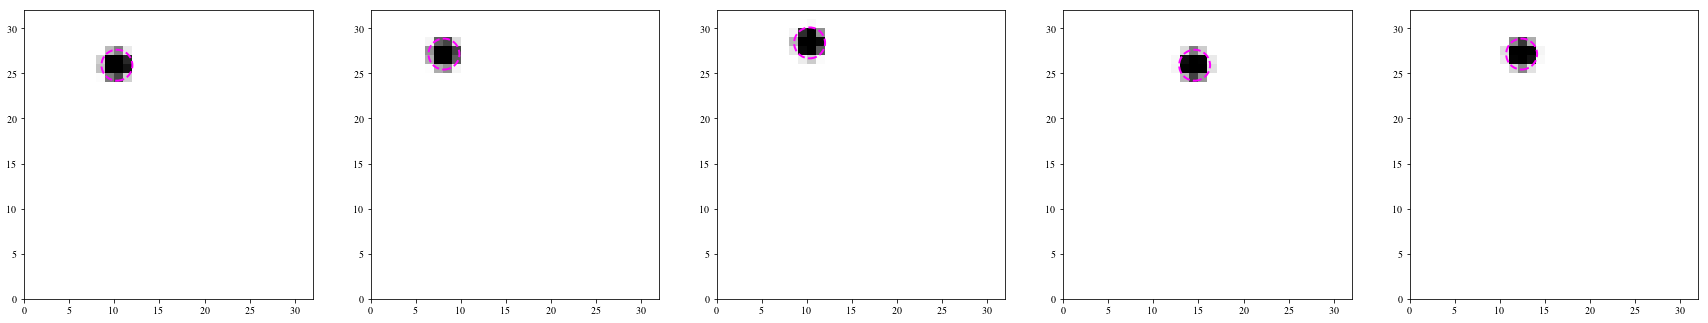

In [6]:
data = np.ones((1024,data_shape,data_shape))

N_fibers = len(xc_cores_pixels)
size_y = data.shape[1]
size_x = data.shape[2]

output_grid_dims = (16,16)

start = time.time()
core_arrays,weight_map = Fiber_Observe(data,xc_cores_pixels,yc_cores_pixels,diam_cores_pixels,
                                       return_weights=True)
print("Time to complete (s):",time.time()-start,'\n')
fig,axarr = plt.subplots(1,5,figsize=(30,6))

for i in np.arange(5):
    ax = axarr[i]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,data_shape,0,data_shape),origin='lower',vmin=0)

    core = Circle(xy=(xc_cores_pixels[i],yc_cores_pixels[i]),radius=diam_cores_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

print("Comparison of individual elements of core_array:\n",core_arrays[0,0],np.pi*(diam_cores_pixels/2)**2)
print("Comparison of sum along N_fibers axis:\n",np.sum(core_arrays,axis=0)[0],N_fibers*np.pi*(diam_cores_pixels/2)**2)

The next step is the coordinate system change from the original data grid to the arbitrary grid onto which the intensities in the fibers are to be distributed. This is set above with the `output_grid_dims` parameter. Below I show the time taken to do the change of coordinates and plot the fiber core locations and sizes in the new grid coordinates.

Note that the coordinates produced by `Change_Coords` will always encompass the same field of view. The only thing that is changing is the pixel scale within that FOV. If desired, one can always zero-pad or crop the original cube or output to modify the FOV.

Time to complete (s): 0.0003173351287841797 



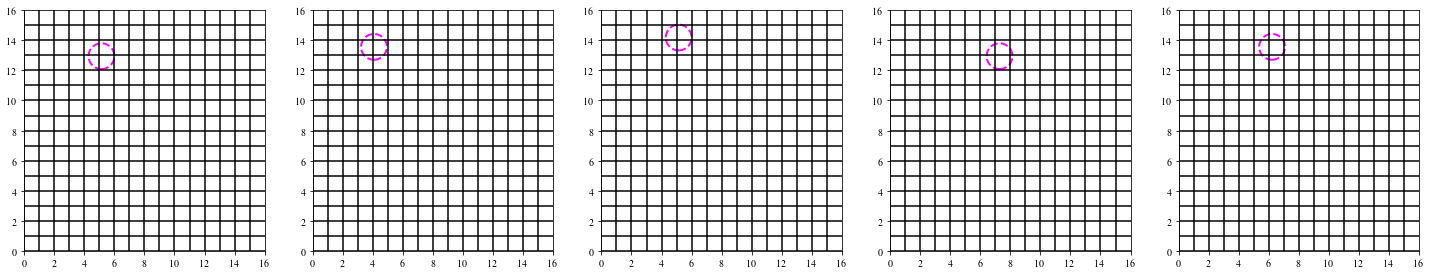

In [7]:
start = time.time()
core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(xc_cores_pixels,yc_cores_pixels,diam_cores_pixels,
                                                                 input_grid_dims=(data_shape,data_shape),
                                                                 output_grid_dims=output_grid_dims)
print("Time to complete (s):",time.time()-start,'\n')
fig,axarr = plt.subplots(1,5,figsize=(25,5))

for i in np.arange(5):
    ax = axarr[i]
    ax.imshow(np.zeros(output_grid_dims),cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
              origin='lower',vmin=0)
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    for j in range(output_grid_dims[0]):
        ax.axhline(j,c='black')
        ax.axvline(j,c='black')


Lastly I check that the output from `Fiber_to_Grid` is realistic and examine the weights. In this test, I use the second method allowed by `Fiber_to_Grid` enabled by setting `use_gaussian_weights=True`. In this case, the intensity in the input data cube should be conserved in the output data as long as `lrim_pixels=None`. If not, then the intensity in the output will be less than in the input. I also plot the weight maps for the first five fibers on the new grid where `use_gaussian_weights=True` and `lrim_pixels=None`. Finally, I plot the first slice of the output datacube to show that the grid is completely covered when `lrim_pixels=None` as the weights extend to infinity for each fiber in this case.

Note the irregular shapes of the weight maps. This is because each pixel is being assigned a **relative** intensity contribution from each fiber according to its distance from that fiber with respect to other fibers (i.e. normalization over the gaussian weights from every fiber). Fibers near the edges fill in parts outside the grid. By setting `lrim_pixels` to some value, the weight a fiber to pixels beyond `lrim_pixels` from its core is zero.

I compute the sums along the spatial axes to show that the intensity from the input cube is conserved in the output.

Time to complete (s): 0.16305112838745117 

in_cube [1024. 1024. 1024. ... 1024. 1024. 1024.]
out_cube [1024.04930564 1024.04930564 1024.04930564 ... 1024.04930564 1024.04930564
 1024.04930564]


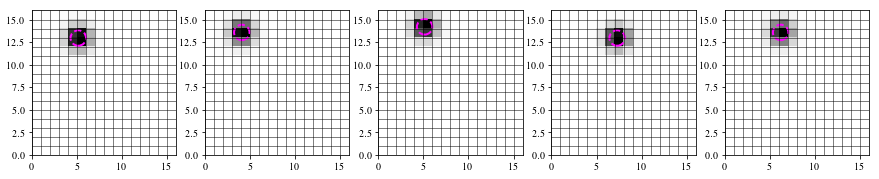

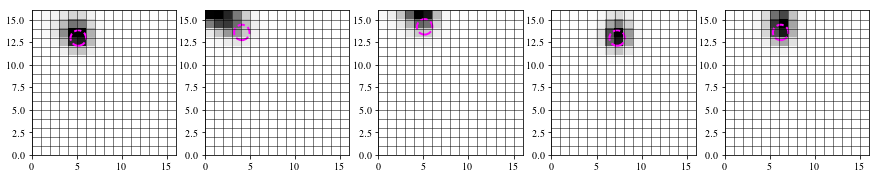

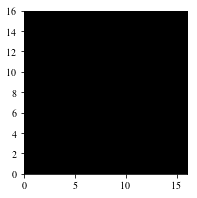

In [8]:
start = time.time()

out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=1.,rlim_pixels=None)

print("Time to complete (s):",time.time()-start,'\n')

print("in_cube", np.sum(data,axis=(1,2)))
print("out_cube", np.sum(out_cube,axis=(1,2)))

fig,axarr = plt.subplots(1,5,figsize=(15,3))

for i in np.arange(5):
    ax = axarr[i]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
              origin='lower',vmin=0)
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    for j in range(output_grid_dims[0]):
        ax.axhline(j,c='black',lw=0.5)
        ax.axvline(j,c='black',lw=0.5)

fig,axarr = plt.subplots(1,5,figsize=(15,3))

alpha = 1./(np.pi*(core_diameter_pixels/2)**2)
normalization = np.sum(weight_map,axis=0)
normalization[normalization==0]=np.nan
weight_map/=normalization
weight_map*=alpha
weight_map[np.isnan(weight_map)]=0

for i in np.arange(5):
    ax = axarr[i]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
              origin='lower',vmin=0)
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    for j in range(output_grid_dims[0]):
        ax.axhline(j,c='black',lw=0.5)
        ax.axvline(j,c='black',lw=0.5)
        
fig,ax = plt.subplots(figsize=(3,3))
ax.imshow(out_cube[0],cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
              origin='lower',vmin=0,vmax=1)

Now let's try it with `lrim_pixels=1.5` which is equal to 1.5 core radii away from the fiber centroids. In this case, we see that the intensity of the input is **not** conserved in the output. This is because (1) the fiber array does not cover the input grid entirely **and** (2) the gaussian weights no longer extend to infinity. 

This is nicely demonstrated in the first slice of the output data cube. Only pixels that are 2 pixels away from any fiber core centroid have values. This is why intensity is not conserved.

In general, intensity will not be conserved unless there is complete sampling of the input cube. This is realistic and since our objective is to be realistic, there is no avoiding it. Indeed, it is this exact stategy that is used by the MaNGA data reduction pipeline (see Section 9.1 of Law et al. 2016, AJ, 152, 83). You can see that the output map looks very MaNGA-like, indeed.

Time to complete (s): 0.16446590423583984 

in_cube [1024. 1024. 1024. ... 1024. 1024. 1024.]
out_cube [775.99061058 775.99061058 775.99061058 ... 775.99061058 775.99061058
 775.99061058]


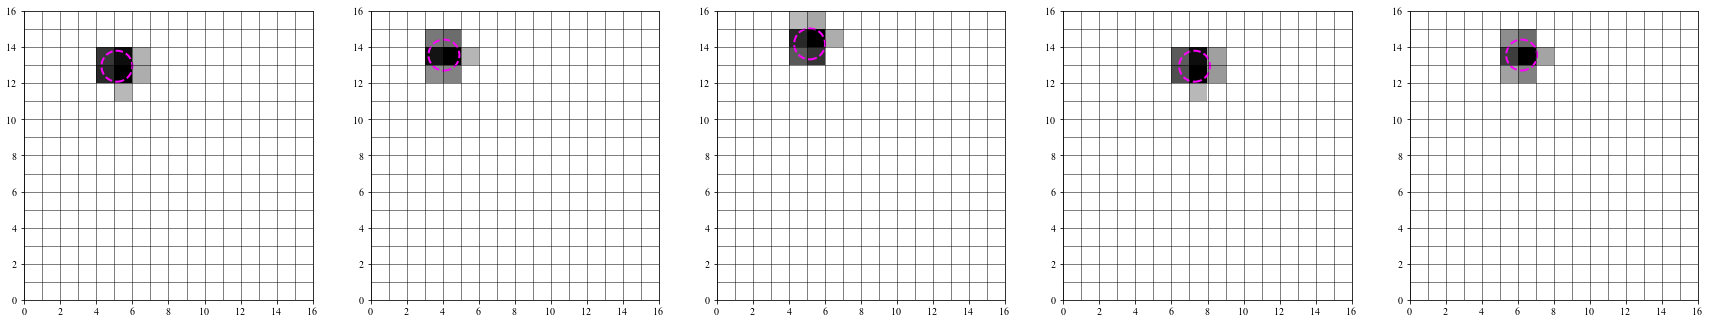

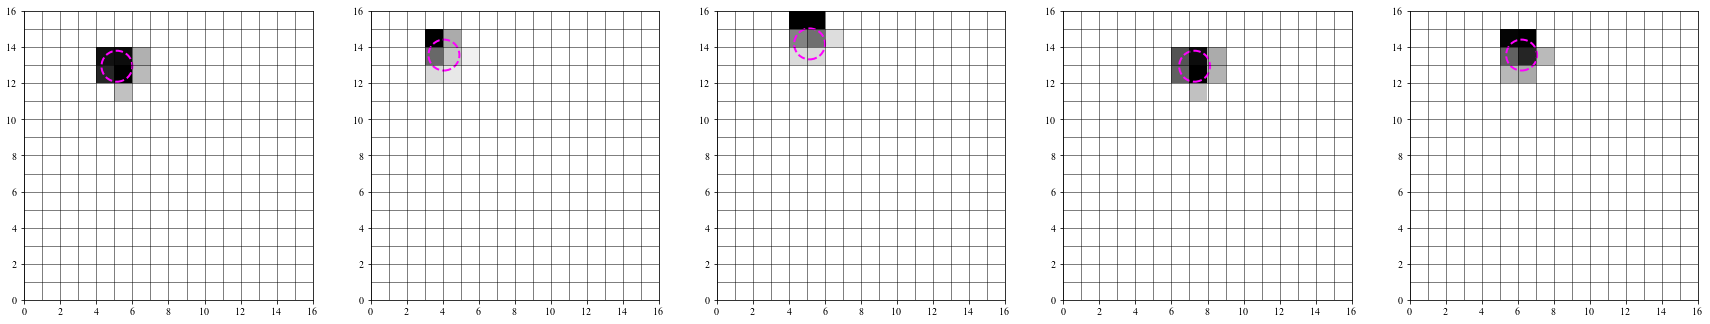

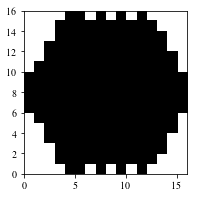

In [9]:
start = time.time()

out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=1.,rlim_pixels=1.5)

print("Time to complete (s):",time.time()-start,'\n')

print("in_cube", np.sum(data,axis=(1,2)))
print("out_cube", np.sum(out_cube,axis=(1,2)))

fig,axarr = plt.subplots(1,5,figsize=(30,6))

for i in np.arange(5):
    ax = axarr[i]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
              origin='lower',vmin=0)
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    for j in range(output_grid_dims[0]):
        ax.axhline(j,c='black',lw=0.5)
        ax.axvline(j,c='black',lw=0.5)
        
fig,axarr = plt.subplots(1,5,figsize=(30,6))

alpha = 1./(np.pi*(core_diameter_pixels/2)**2)
normalization = np.sum(weight_map,axis=0)
normalization[normalization==0]=np.nan
weight_map/=normalization
weight_map*=alpha
weight_map[np.isnan(weight_map)]=0
    
for i in np.arange(5):
    ax = axarr[i]
    ax.imshow(weight_map[i],cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
              origin='lower',vmin=0)
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
    for j in range(output_grid_dims[0]):
        ax.axhline(j,c='black',lw=0.5)
        ax.axvline(j,c='black',lw=0.5)
        
fig,ax = plt.subplots(figsize=(3,3))
ax.imshow(out_cube[0],cmap='Greys',extent=(0,output_grid_dims[1],0,output_grid_dims[0]),
          origin='lower',vmin=0)
